In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Convolution2D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import scipy.stats as stats

In [2]:

data = pd.read_csv('data/app_data.csv', index_col=False)
data = data.dropna()
data['X'] = data['X'].astype(float)
data['Y'] = data['Y'].astype(float)
data['Z'] = data['Z'].astype(float)
data['Activity'] = data['Activity'].str.rstrip(';')
data['Activity'] = data['Activity'].str.strip()
corrections = {
    'Walkin': 'Walking',
    'Eating Popconr': 'Eating Popcorn'
}
data['Activity'] = data['Activity'].replace(corrections)

/var/folders/mn/35k8vrvj7z9046dsf_t68vzh0000gn/T/ipykernel_33592/140840955.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv('data/app_data.csv', index_col=False)


In [3]:
# Isolate the X, Y, Z
data = data.drop(['SessionID', 'DeviseID', 'UserID', 'Date', 'Year', 'TimeStamp'], axis=1)
# Balance the dataset by selecting a specific number of rows for each activity
drinking_water = data[data['Activity'] == 'Drinking Water'].head(1200)
vaping = data[data['Activity'] == 'Vaping'].head(1200)
typing = data[data['Activity'] == 'Typing'].head(1200)
eating_popcorn = data[data['Activity'] == 'Eating Popconr'].head(1200)
walking = data[data['Activity'] == 'Walking'].head(1200)
balanced_data = pd.DataFrame()
balanced_data = pd.concat([drinking_water, vaping, typing, eating_popcorn, walking])


In [4]:
# Encode the activity label
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['Activity'])

In [6]:
scaler = StandardScaler()
X = balanced_data[['X', 'Y', 'Z']]
X = scaler.fit_transform(X)

In [7]:
scaled_X = pd.DataFrame(data=X, columns=['X', 'Y', 'Z'])
scaled_X['label'] = balanced_data['label'].values

In [8]:
scaled_X.shape

(4800, 4)

In [9]:
label.classes_

array(['Drinking Water', 'Typing', 'Vaping', 'Walking'], dtype=object)

In [10]:
def get_windows(df, window_size, step_size):
    

    windows = []
    labels = []
    num_features = 3
    for i in range(0, len(df) - window_size, step_size):
        xs = df['X'].values[i: i + window_size]
        ys = df['Y'].values[i: i + window_size]
        zs = df['Z'].values[i: i + window_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + window_size])[0]
        windows.append([xs, ys, zs])
        labels.append(label)
        
    windows = np.asarray(windows).reshape(-1, window_size, num_features)
    labels = np.asarray(labels)
    
    return windows, labels

In [11]:
window_size, step_size = 100, 50
x, y = get_windows(scaled_X, window_size, step_size)

In [12]:
x.shape, y.shape

((94, 100, 3), (94,))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1, stratify=y)

In [18]:
X_train.shape , X_test.shape

((766, 10, 3), (192, 10, 3))

In [15]:
print("Original shape of X_train:", X_train.shape)
print("Total elements in X_train:", X_train.size)

Original shape of X_train: (75, 100, 3, 1)
Total elements in X_train: 22500


In [16]:
num_samples = X_train.shape[0]
window_size = X_train.shape[1]
num_features = X_train.shape[2]
print(f"Num Samples: {num_samples}, Window Size: {window_size}, Num Features: {num_features}")


Num Samples: 75, Window Size: 100, Num Features: 3


In [24]:
X_train = X_train.reshape(-1, window_size, 3, 1)  # Replace `10` and `3` with actual values
X_test = X_test.reshape(-1, window_size, 3, 1)   # Ensure the same reshaping logic


In [25]:
# Step 9: Define CNN Model
model = Sequential([
    Convolution2D(16, (2, 2), activation='relu', input_shape=X_train[0].shape),
    Dropout(0.1),
    Convolution2D(32, (2, 2), activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Step 10: Train the Model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32, verbose=1)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.2705 - loss: 1.7583 - val_accuracy: 0.6842 - val_loss: 1.4712
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5934 - loss: 1.3514 - val_accuracy: 0.7368 - val_loss: 1.1804
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6281 - loss: 1.1311 - val_accuracy: 0.6842 - val_loss: 0.9372
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6649 - loss: 0.9581 - val_accuracy: 0.7368 - val_loss: 0.7600
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6314 - loss: 0.8125 - val_accuracy: 0.8421 - val_loss: 0.6429
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6603 - loss: 0.7549 - val_accuracy: 0.8421 - val_loss: 0.5680
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7499 - loss: 0.6203 - val_accuracy: 0.8421 - val_loss: 0.5254
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7460 - loss: 0.6650 - val_accuracy: 0.7895 - val_loss: 0.5148


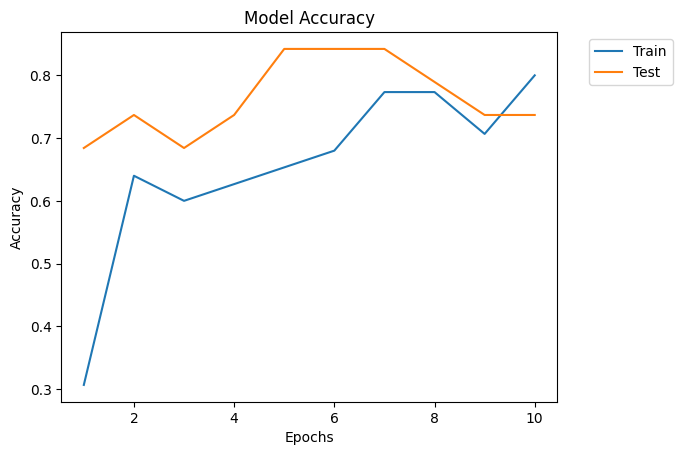

In [26]:
# Learning Curve
# Plot training and validataion accuracy values
epoch_range = range(1, 11)
plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'], bbox_to_anchor=(1.05, 1))
plt.show()


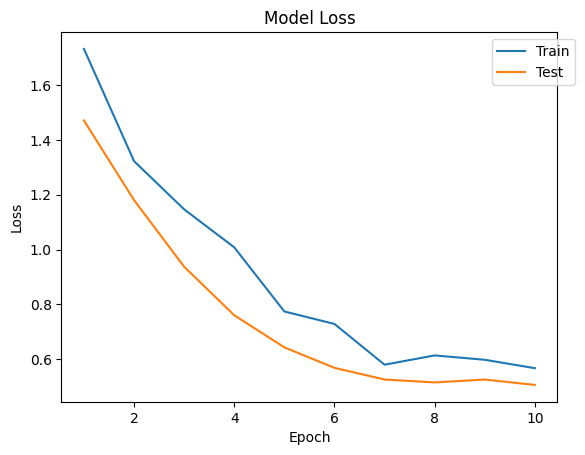

In [27]:
# Plot of training and validation loss:
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'], bbox_to_anchor=(1.05, 1))
plt.show()

In [28]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [29]:
y_pred = np.argmax(model.predict(X_test), axis=-1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


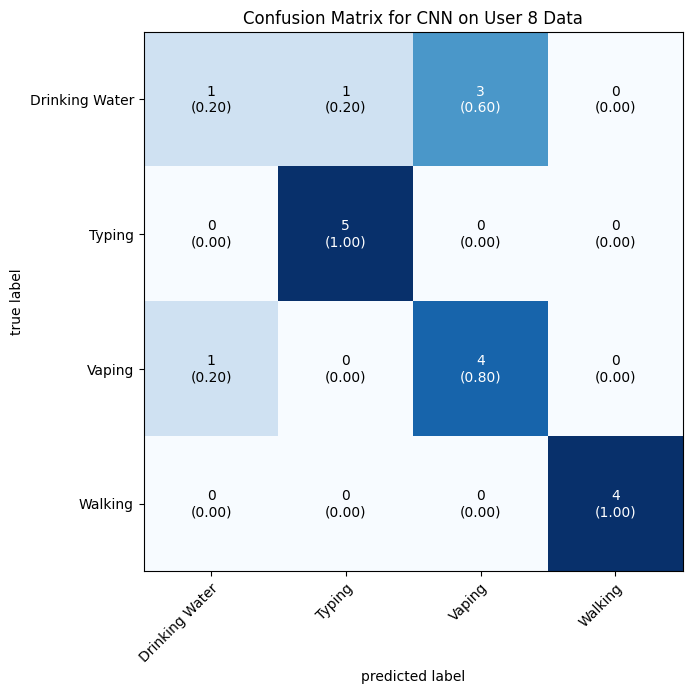

In [30]:
# Step 12: Evaluate Model with Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=-1)
matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=matrix, class_names=label.classes_, show_normed=True, figsize=(7, 7))
plt.title('Confusion Matrix for CNN on User 8 Data')
plt.show()